In [1]:
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats

base_dir = os.path.dirname(os.path.abspath(""))
data_folder = os.path.join(base_dir, "data/regular_season")

In [2]:
font_path = "./assets/fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f"{font_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{font_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
            except Exception:
                continue

plt.style.use("assets/stylesheets/fdp_base.mplstyle")

In [3]:
df = pd.concat([pd.read_csv(os.path.join(data_folder, file_name)) for file_name in os.listdir(data_folder)])

df.shape

(2796750, 15)

In [5]:
df_copy = df.copy()

In [6]:
def return_top_n_df(data:pd.DataFrame=df_copy, n:int=1) -> pd.DataFrame:
        """
        Return top n picks for each draft entry
        """
        data = data.sort_values(['tournament_entry_id','overall_pick_number'],ascending=True).groupby('tournament_entry_id').head(n)
        data = data.loc[data['position_name'].notnull()]
        data['position_name'] = data['position_name'].astype(str)
        data = data.groupby(['tournament_entry_id']).agg({
              'position_name': lambda x: '-'.join(x),
              'pick_points': np.sum,
              'roster_points': 'first'
          }).reset_index(drop=True)
        data = data.groupby('position_name').agg({
              'pick_points': np.mean,
              'roster_points': np.mean
          }).reset_index()
        return data

In [7]:
all_picks_df = pd.DataFrame()
for n in range(1, 7):
    top_n_df = return_top_n_df(df_copy, n).sort_values(by='roster_points', ascending=False)
    top_n_df['picks'] = n
    all_picks_df = pd.concat([all_picks_df, top_n_df])
    
positions = ['RB', 'WR', 'TE', 'QB']
all_picks_df = all_picks_df.rename({
    'position_name': 'pick_order'
}, axis=1)
for position in positions:
    all_picks_df[position] = all_picks_df['pick_order'].apply(lambda x: x.split('-').count(position))

In [8]:
top_5_picks_df = all_picks_df.loc[all_picks_df['picks'] == 5]

top_5_picks_df.head()

,pick_order,pick_points,roster_points,picks,RB,WR,TE,QB
544,WR-QB-QB-RB-TE,739.820,1853.520,5,1,1,1,2
388,TE-QB-WR-WR-QB,578.740,1751.200,5,0,2,1,2
591,WR-RB-QB-TE-TE,746.495,1673.805,5,1,1,2,1
677,WR-TE-TE-WR-QB,775.150,1673.340,5,0,2,2,1
102,QB-WR-TE-RB-QB,727.140,1662.300,5,1,1,1,2


101
656


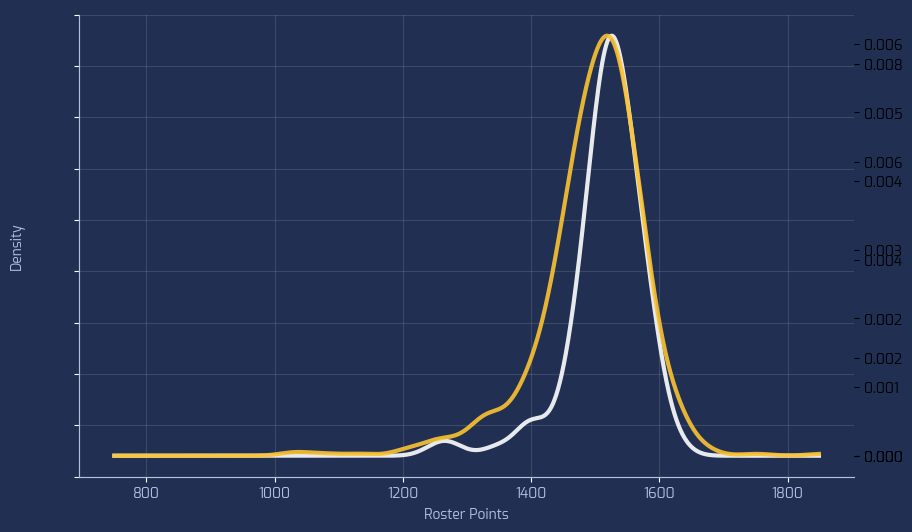

In [54]:
#fifth picks
robust_wr = top_5_picks_df.loc[top_5_picks_df['WR'] >= 3]
robust_rb = top_5_picks_df.loc[top_5_picks_df['RB'] >= 3]
all_other_strategies = top_5_picks_df.loc[top_5_picks_df['WR'] < 3]
print(len(robust_wr))
print(len(all_other_strategies))
fig, ax = plt.subplots(figsize=(10, 6))

par1 = ax.twinx()
par2 = ax.twinx()

kde_a = scipy.stats.gaussian_kde(robust_wr.roster_points)
kde_b = scipy.stats.gaussian_kde(all_other_strategies.roster_points)
grid = np.arange(750, 1850)
l1 = par1.plot(grid, kde_a(grid), color='white', lw=3, alpha=0.9)
l2 = par2.plot(grid, kde_b(grid), color='#fcc331', lw=3, alpha=0.9)
ax.grid(alpha=0.2);
ax.set_facecolor('#202f52');
fig.set_facecolor('#202f52');
ax.tick_params(axis='x', color='w', labelcolor='#b3c1e1')
ax.tick_params(axis='y', color='w', labelcolor='#202f52')
for spine in par1.spines.values():
    spine.set_edgecolor('#b3c1e1')
for spine in par2.spines.values():
    spine.set_edgecolor('#b3c1e1')
ax.set_xlabel('Roster Points', color='#b3c1e1')
ax.set_ylabel('Density', color='#b3c1e1');
ax.set_yticks(np.linspace(0, 1, 10));
for i in ax.yaxis.get_ticklines():
    i.set_color('#202f52')

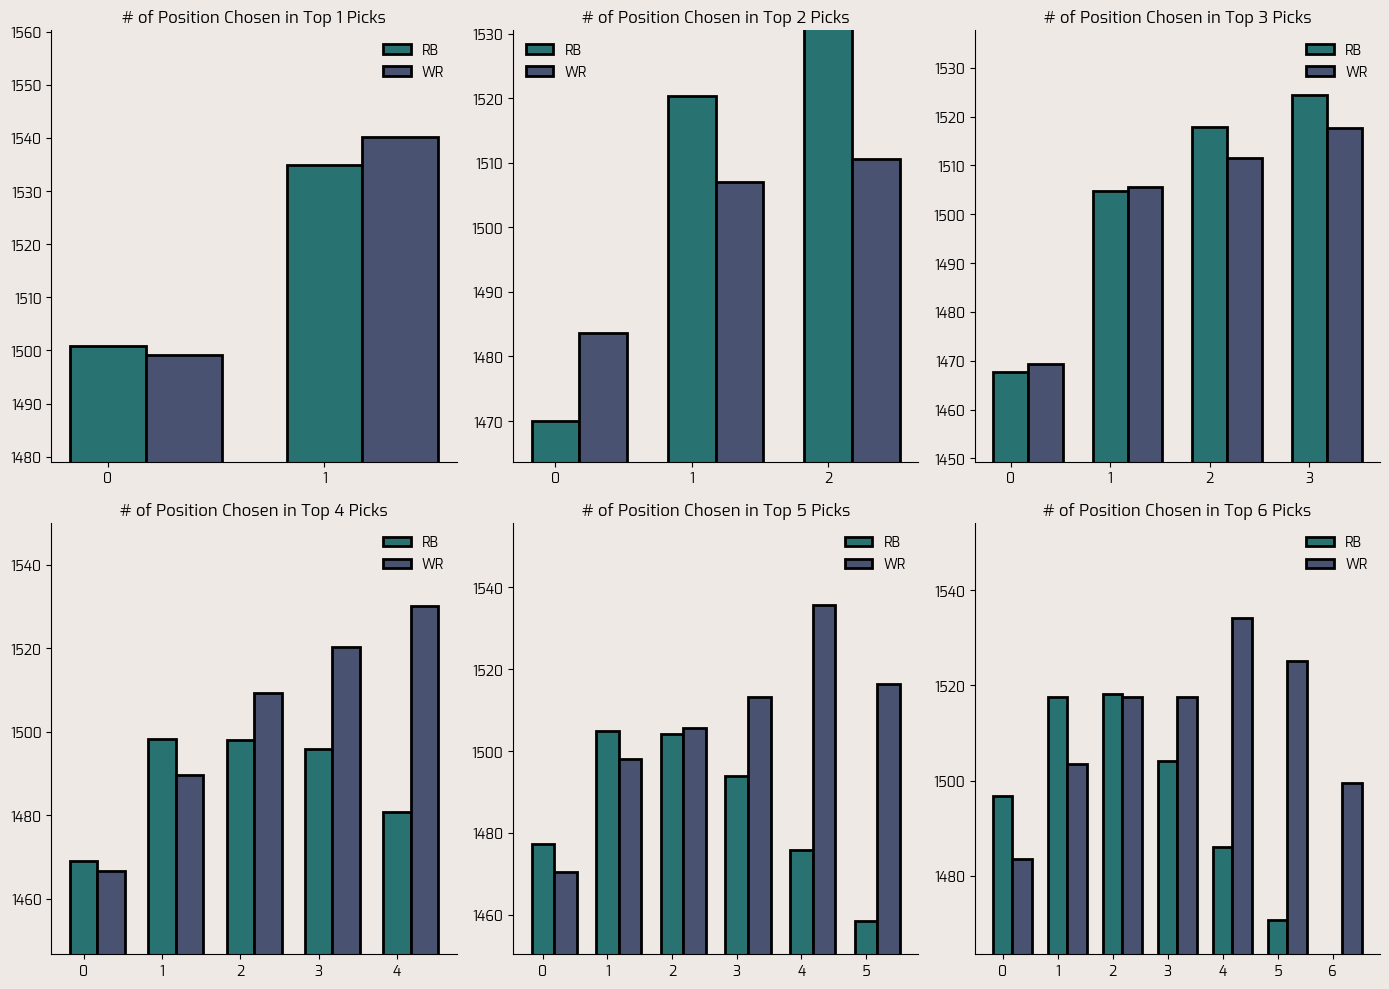

In [32]:
rb_df_picks_dfs = [group_df for _, group_df in rb_df.groupby('picks')]
wr_df_picks_dfs = [group_df for _, group_df in wr_df.groupby('picks')]
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()
width=0.35
for i, (rb_df_i, ax) in enumerate(zip(rb_df_picks_dfs[:6], axes)):
    ax.bar(x=rb_df_i['RB'], height=rb_df_i['roster_points'], width=0.35, ec='black', lw=2)
    ax.set_ylim([rb_df_i['roster_points'].min() - 5, rb_df_i['roster_points'].max() + 5])
    ax.set_xticks(range(i + 2))

for i, (wr_df_i, ax) in enumerate(zip(wr_df_picks_dfs[:6], axes)):
    ax.set_title(f'# of Position Chosen in Top {i + 1} Picks')
    ax.bar(x=wr_df_i['WR'] + width, height=wr_df_i['roster_points'], width=width, ec='black', lw=2)
    ax.set_ylim([wr_df_i['roster_points'].min() - 20, wr_df_i['roster_points'].max() + 20])
    ax.set_xticks(range(i + 2))
    ax.legend(['RB', 'WR'])
    
plt.tight_layout()